In [1]:
#TODO
#logistic regression / linear regression
#time from the peak
#weekly variant
#trend based linear regression / time series analysis
#add average sales, 3m,6m, 12m, YOY
#Survival Analysis
#Add survey response
########
#How many clients "churned"?
#Is object sales value making users more prone to quit?
#build second model?
#weekly, monthly, yearly, YOY performance
#set the target variable
#assign the trend to each customer and then plot it.
#average change during last 6 months? YOY?

#number of zero sales during last period?
#sales week before
#trend strike
#diff of mean sales?

Churn Prediction
Pattern
There are 3 aggregated reasons of Churn (resignation of service by client) defined by Payability customer service:
    1. No longer active on Amazon (27% last 12 mths)
        I. Supplier’s sales decline, leading to end of business
    2. Outgrew Payability (27% last 12 mths)
        I. Supplier’s sales significantly incline and Supplier is getting other financing
    3. Product complaint (46% last 12 mths)
Task
Analyse first 2 points of above Churn reasons.

Having sales history data, prepare a model classifying the trend of sales as inclining or declining [or any other you see useful] and test the accuracy of model on given dataset. Check whether is there correlation of trend movement to churn event (churn happened if there is a date given in churn dataset – if there is no date, the client is still using our service) – verify the hipothesis stated by Customer Service.

Provide GitHub (or any similar, BitBucket etc.) link to Python script that you created during the analysis.

In [19]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm
from sklearn.model_selection import StratifiedKFold
import multiprocessing as mp 

In [3]:
perf = pd.read_csv('seller_performance_data.csv', sep=';', low_memory=False).drop('Unnamed: 0', axis = 1)
churn = pd.read_csv('churn_data.csv', sep=';').drop('Unnamed: 0', axis = 1)

In [4]:
#set the right dtypes
perf.report_date = pd.to_datetime(perf.report_date)
churn.churn_date = pd.to_datetime(churn.churn_date)

perf.ordered_product_sales = perf.ordered_product_sales.apply(lambda x: 
                                                str(x).replace(',','.')).astype('float32')
perf.ordered_product_sales_b2b = perf.ordered_product_sales_b2b.apply(lambda x: 
                                                str(x).replace(',','.')).astype('float32')

# Overall Checks

In [6]:
#Do we have performance data for all churned clients?

In [9]:
round(len(perf.loc[perf.supplier_key.isin(churn.supplier_key),'supplier_key'].unique()) / \
len(churn.supplier_key.unique()),3)

0.901

10% of performance data for customers who did quit is missing. Let's find out who those are.

In [11]:
set(churn.supplier_key.unique()).difference(set(perf.supplier_key.unique()))

{'093222f2-0030-4b9f-833e-b1395b1cf824',
 '2c624e3d-30a6-4328-9767-c78100ab26c7',
 '4408ef25-a930-42c2-9036-d2a73dba06f0',
 '45cdfd3b-7092-4e6f-a373-8f384a7f4304',
 '6d8136e4-8c5a-43f4-9d66-4c284766a81a',
 '6f9fbc7d-23fc-4a13-9223-971ec59ea175',
 '7a32a17c-3b0a-41ca-ae95-ce6b76e85dea',
 '815c6552-086b-420f-bd78-989254bcb34d',
 '898b3237-3a03-459f-b1e0-b4e285aaeedd',
 'a776a378-a343-4286-98a3-6675d68e2f51',
 'cb87344a-5db9-45c0-9c54-e7dd285faeee',
 'da98671d-70b6-44e0-9cc3-00d681092bb3',
 'f3501f9c-70c0-40d6-ba0c-e679b30e7e74',
 'fa2e1a47-ba8a-4f12-b117-f11ec117a4ef'}

Let's have a look at the data

In [12]:
perf.describe()

,ordered_product_sales,ordered_product_sales_b2b,units_ordered,units_ordered_b2b,units_refunded
count,278975.000000,278975.000000,278975.000000,278975.000000,278975.000000
mean,931.690002,27.646441,37.082502,1.036233,0.755806
std,4914.086426,330.797028,271.206070,14.744259,7.888461
min,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,32.980000,0.000000,1.000000,0.000000,0.000000
75%,397.769989,0.000000,14.000000,0.000000,0.000000
max,307322.437500,16839.220703,24333.000000,1867.000000,1582.000000


In [14]:
perf.corr()

,ordered_product_sales,ordered_product_sales_b2b,units_ordered,units_ordered_b2b,units_refunded
ordered_product_sales,1.000000,0.380320,0.866981,0.408478,0.554738
ordered_product_sales_b2b,0.380320,1.000000,0.350937,0.917082,0.298353
units_ordered,0.866981,0.350937,1.000000,0.431610,0.632785
units_ordered_b2b,0.408478,0.917082,0.431610,1.000000,0.343540
units_refunded,0.554738,0.298353,0.632785,0.343540,1.000000


In [13]:
churn.describe()

,supplier_key,churn_date
count,141,141
unique,141,131
top,3e0e0fa2-46b4-4aa2-ac95-19d2daa462a4,2018-02-15 00:00:00
freq,1,4
first,NaN,2016-01-25 00:00:00
last,NaN,2018-11-16 00:00:00


Probably the best way to see what's going one before some quits is to plot the revenu again the time 

In [16]:
jdf = pd.merge(perf, churn, on = 'supplier_key', how = 'left')
jdf['days_to_churn'] = jdf.churn_date - jdf.report_date
jdf['days_to_churn'] = jdf['days_to_churn'].apply(lambda x: x.days)
jdf = jdf.loc[~jdf['days_to_churn'].isnull(),:]
jdf = jdf.loc[jdf['days_to_churn'] >= 0,:]
jdf.shape

(109383, 9)

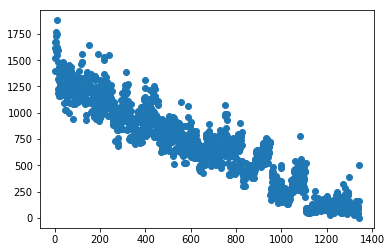

In [17]:
plt.scatter(jdf.groupby('days_to_churn').mean().index, \
            jdf.groupby('days_to_churn').mean()['ordered_product_sales'])

There seems to be a corelation between number of days left to quit and mean sales value but it's weirdly linear. Let's plot few examples.

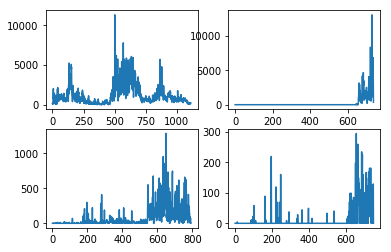

In [18]:
jdf = jdf.sort_values(by=['supplier_key','report_date']).reset_index()
plt.subplot(2, 2, 1)
plt.plot(jdf.loc[jdf.supplier_key == jdf.supplier_key.unique() \
                 [np.random.randint(len(jdf.supplier_key.unique()))],'ordered_product_sales'].values)

plt.subplot(2, 2, 2)
plt.plot(jdf.loc[jdf.supplier_key == jdf.supplier_key.unique()\
                 [np.random.randint(len(jdf.supplier_key.unique()))],'ordered_product_sales'].values)

plt.subplot(2, 2, 3)
plt.plot(jdf.loc[jdf.supplier_key == jdf.supplier_key.unique()\
                 [np.random.randint(len(jdf.supplier_key.unique()))],'ordered_product_sales'].values)

plt.subplot(2, 2, 4)
plt.plot(jdf.loc[jdf.supplier_key == jdf.supplier_key.unique()\
                 [np.random.randint(len(jdf.supplier_key.unique()))],'ordered_product_sales'].values)


There are zeros at the beginning of some of time series. They should be removed.

In [20]:
jdf.drop('index', axis = 1, inplace=True)
jdf.loc[:,'beginZero'] = 0

In [26]:
def removeZeros(i):
        if (i == 0) & (jdf.loc[jdf.index == i,'ordered_product_sales'].values == 0):
            return pd.DataFrame(
                    [[
                      jdf.loc[jdf.index == i,'supplier_key'].values[0],
                        jdf.loc[jdf.index == i,'report_date'].values[0],
                        jdf.loc[jdf.index == i,'ordered_product_sales'].values[0],
                        1
                    ]],
            columns=['supplier_key','report_date','ordered_product_sales','beginZero'])
        if jdf.loc[jdf.index == i,'supplier_key'].values == jdf.loc[jdf.index == i-1,'supplier_key'].values:
            if (jdf.loc[jdf.index == i,'ordered_product_sales'].values == 0) & \
            (jdf.loc[jdf.index == (i-1),'ordered_product_sales'].values == 0):  
                return pd.DataFrame(
                        [[
                          jdf.loc[jdf.index == i,'supplier_key'].values[0],
                            jdf.loc[jdf.index == i,'report_date'].values[0],
                            jdf.loc[jdf.index == i,'ordered_product_sales'].values[0],
                            1
                        ]],
                columns=['supplier_key','report_date','ordered_product_sales','beginZero'])
            else:
                return pd.DataFrame(
                        [[
                          jdf.loc[jdf.index == i,'supplier_key'].values[0],
                            jdf.loc[jdf.index == i,'report_date'].values[0],
                            jdf.loc[jdf.index == i,'ordered_product_sales'].values[0],
                            0
                        ]],
                columns=['supplier_key','report_date','ordered_product_sales','beginZero'])
        else:
            if (jdf.loc[jdf.index == i,'ordered_product_sales'].values == 0):
                return pd.DataFrame(
                        [[
                          jdf.loc[jdf.index == i,'supplier_key'].values[0],
                            jdf.loc[jdf.index == i,'report_date'].values[0],
                            jdf.loc[jdf.index == i,'ordered_product_sales'].values[0],
                            1
                        ]],
                columns=['supplier_key','report_date','ordered_product_sales','beginZero'])
            else:
                return pd.DataFrame(
                            [[
                              jdf.loc[jdf.index == i,'supplier_key'].values[0],
                            jdf.loc[jdf.index == i,'report_date'].values[0],
                            jdf.loc[jdf.index == i,'ordered_product_sales'].values[0],
                                0
                            ]],
                    columns=['supplier_key','report_date','ordered_product_sales','beginZero'])
 

In [27]:
%%time
pool = mp.Pool(processes = (mp.cpu_count()))
results = pool.map(removeZeros, range(jdf.shape[0]))
pool.close()
pool.join()

resdf = pd.concat(results)

CPU times: user 43 s, sys: 605 ms, total: 43.6 s
Wall time: 1min 1s


In [28]:
jdf = pd.merge(jdf,resdf, on = ['supplier_key','report_date'], suffixes=['_toDel',''])
jdf.drop(['ordered_product_sales_toDel'], axis = 1, inplace=True)
jdf = jdf.loc[jdf.beginZero == 0,:]

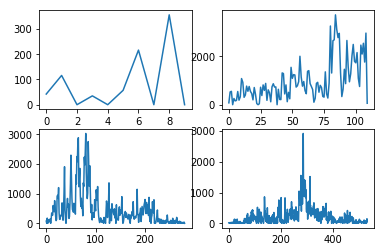

In [29]:
plt.subplot(2, 2, 1)
plt.plot(jdf.loc[jdf.supplier_key == jdf.supplier_key.unique() \
                 [np.random.randint(len(jdf.supplier_key.unique()))],'ordered_product_sales'].values)

plt.subplot(2, 2, 2)
plt.plot(jdf.loc[jdf.supplier_key == jdf.supplier_key.unique()\
                 [np.random.randint(len(jdf.supplier_key.unique()))],'ordered_product_sales'].values)

plt.subplot(2, 2, 3)
plt.plot(jdf.loc[jdf.supplier_key == jdf.supplier_key.unique()\
                 [np.random.randint(len(jdf.supplier_key.unique()))],'ordered_product_sales'].values)

plt.subplot(2, 2, 4)
plt.plot(jdf.loc[jdf.supplier_key == jdf.supplier_key.unique()\
                 [np.random.randint(len(jdf.supplier_key.unique()))],'ordered_product_sales'].values)


Now it's better

Text(0, 0.5, 'Sales')

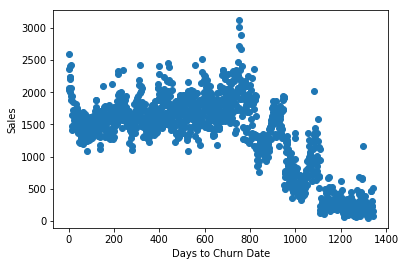

In [30]:
#inclines and declines cancel each either out?
plt.scatter(jdf.groupby('days_to_churn').mean().index, jdf.groupby('days_to_churn').mean() \
            ['ordered_product_sales'])
plt.xlabel('Days to Churn Date')
plt.ylabel('Sales')

Text(0, 0.5, 'Sales')

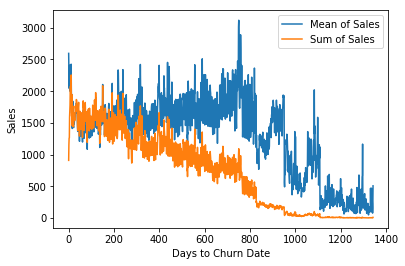

In [31]:
#inclines and declines cancel each either out?
plt.plot(jdf.groupby('days_to_churn').mean()['ordered_product_sales'])
plt.plot(jdf.groupby('days_to_churn').sum()['ordered_product_sales']/100)
plt.legend(['Mean of Sales', 'Sum of Sales'])
plt.xlabel('Days to Churn Date')
plt.ylabel('Sales')

The linearity is gone but the pic is hardly readable. It would be useful to get weekly aggregations

In [32]:
jdf['year'] = jdf.report_date.dt.year
#jdf['month'] = jdf.report_date.dt.month
jdf['weekofyear'] = jdf.report_date.dt.weekofyear
# jdf['quarter'] = jdf.report_date.dt.quarter

In [33]:
jdfm = jdf.groupby(['supplier_key', 'year', 'weekofyear']).sum()
jdfm.drop(['days_to_churn', 'beginZero'], axis = 1, inplace=True)
chm = churn.copy()
chm['churned'] = 1
jdfm = jdfm.reset_index().merge(chm, on = ['supplier_key'], how = 'left')

In [34]:
#weeks to churn
jdfm['weeks_to_churn'] = (jdfm.churn_date.dt.year - jdfm.year)*52 - \
    jdfm.weekofyear + jdfm.churn_date.dt.weekofyear

#weeks from start
jdfm['date'] = jdfm.year.map(str) + '-' + jdfm.weekofyear.map(str) + '-' + str(1)
#verify!
jdfm['date'] = pd.to_datetime(jdfm['date'], format='%Y-%W-%w')
jdfm['date'] = jdfm.supplier_key.map(jdfm.groupby('supplier_key').min()['date'])
jdfm['weeks_from_start'] = (jdfm.year*52 + jdfm.weekofyear) - (jdfm.date.dt.year*52 + jdfm.date.dt.weekofyear)
jdfm.drop('date', axis = 1, inplace=True)

Text(0, 0.5, 'Sales')

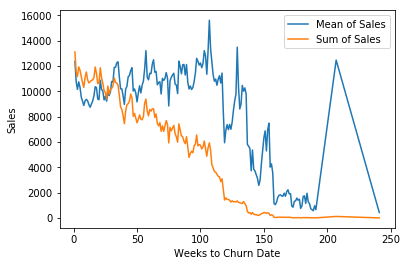

In [35]:
#cancel each either out?
plt.plot(jdfm.loc[jdfm.weeks_to_churn > 0,:].groupby('weeks_to_churn').mean()['ordered_product_sales'])
plt.plot(jdfm.loc[jdfm.weeks_to_churn > 0,:].groupby('weeks_to_churn').sum()['ordered_product_sales']/100)
plt.legend(['Mean of Sales', 'Sum of Sales'])
plt.xlabel('Weeks to Churn Date')
plt.ylabel('Sales')

if the sum of sales is growing and the mean sales stays about the same it has to balanced by slow movers
it seems so, let's separate users who might quit because of lack of sales

In [36]:
jdfm = jdfm.set_index(['supplier_key', 'year','weekofyear'])
jdfm_diff = (jdfm - jdfm.groupby('supplier_key').shift(1))
jdfm_diff = jdfm_diff.reset_index()

In [37]:
for s in jdfm_diff.supplier_key.unique():
    jdfm_diff.loc[jdfm_diff.supplier_key == s,'1wDiffMean'] = \
        jdfm_diff.loc[jdfm_diff.supplier_key == s,'ordered_product_sales'].rolling(1).mean()
    jdfm_diff.loc[jdfm_diff.supplier_key == s,'2wDiffMean'] = \
        jdfm_diff.loc[jdfm_diff.supplier_key == s,'ordered_product_sales'].rolling(2).mean()
    jdfm_diff.loc[jdfm_diff.supplier_key == s,'3wDiffMean'] = \
        jdfm_diff.loc[jdfm_diff.supplier_key == s,'ordered_product_sales'].rolling(3).mean()
    jdfm_diff.loc[jdfm_diff.supplier_key == s,'6wDiffMean'] = \
        jdfm_diff.loc[jdfm_diff.supplier_key == s,'ordered_product_sales'].rolling(6).mean()
    jdfm_diff.loc[jdfm_diff.supplier_key == s,'9wDiffMean'] = \
        jdfm_diff.loc[jdfm_diff.supplier_key == s,'ordered_product_sales'].rolling(9).mean()
    jdfm_diff.loc[jdfm_diff.supplier_key == s,'12wDiffMean'] = \
        jdfm_diff.loc[jdfm_diff.supplier_key == s,'ordered_product_sales'].rolling(12).mean()
    jdfm_diff.loc[jdfm_diff.supplier_key == s,'15wDiffMean'] = \
        jdfm_diff.loc[jdfm_diff.supplier_key == s,'ordered_product_sales'].rolling(15).mean()

In [38]:
jdfm['1wDiffMean'] = jdfm_diff.set_index(['supplier_key', 'year','weekofyear']).loc[:,'1wDiffMean']
jdfm['2wDiffMean'] = jdfm_diff.set_index(['supplier_key', 'year','weekofyear']).loc[:,'2wDiffMean']
jdfm['3wDiffMean'] = jdfm_diff.set_index(['supplier_key', 'year','weekofyear']).loc[:,'3wDiffMean']
jdfm['6wDiffMean'] = jdfm_diff.set_index(['supplier_key', 'year','weekofyear']).loc[:,'6wDiffMean']
jdfm['9wDiffMean'] = jdfm_diff.set_index(['supplier_key', 'year','weekofyear']).loc[:,'9wDiffMean']
jdfm['12wDiffMean'] = jdfm_diff.set_index(['supplier_key', 'year','weekofyear']).loc[:,'12wDiffMean']
jdfm['15wDiffMean'] = jdfm_diff.set_index(['supplier_key', 'year','weekofyear']).loc[:,'15wDiffMean']

In [39]:
jdfm = jdfm.reset_index()

In [40]:
for s in jdfm.supplier_key.unique():
    tsl = jdfm.loc[jdfm.supplier_key == s,:].shape[0]
    tsdf = jdfm.loc[jdfm.supplier_key == s,:]
    tslistmax = list()
    tslistmin = list()
    for l in range(tsl):
        tslistmax.append(tsdf.iloc[0:l,:].loc[:,'ordered_product_sales'].max())
        tslistmin.append(tsdf.iloc[0:l,:].loc[:,'ordered_product_sales'].min())
    jdfm.loc[jdfm.supplier_key == s,'peakSales'] = tslistmax
    jdfm.loc[jdfm.supplier_key == s,'peakSalesMin'] = tslistmin

In [41]:
jdfm['diffPeakMax'] = jdfm['ordered_product_sales'] - jdfm['peakSales']
jdfm['diffPeakMin'] = jdfm['ordered_product_sales'] - jdfm['peakSalesMin']

In [42]:
for s in jdfm.supplier_key.unique():
    jdfm.loc[jdfm.supplier_key == s,'3wMean_of_12wDiffMean'] = \
        jdfm.loc[jdfm.supplier_key == s,'12wDiffMean'].rolling(3).mean()

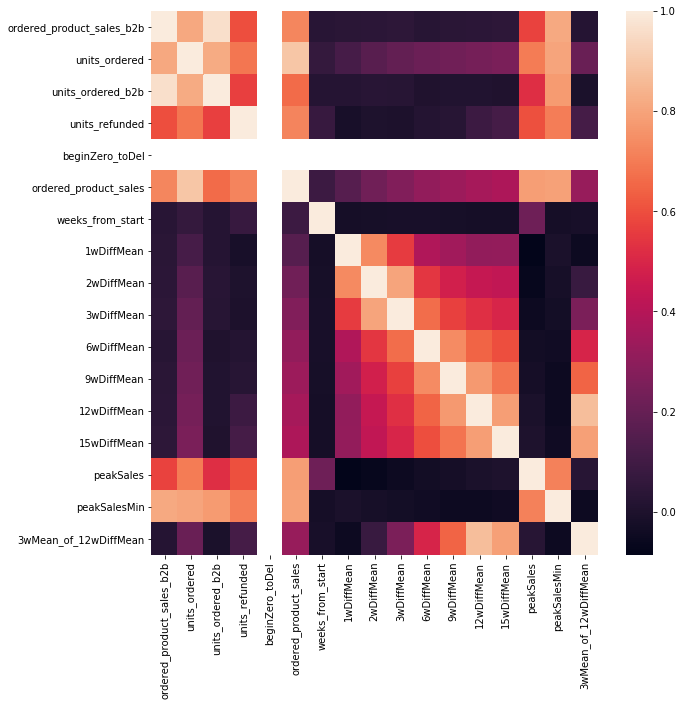

In [43]:
import seaborn as sns

cols_to_exclude = ['supplier_key',
            'year', 'weekofyear', 'index', 'churn_date', 'churned', 'weeks_to_churn', 'trend',
                  '%change1wVs3DiffMean','diffPeakMin','diffPeakMax','%change1wVs1DiffMean',
                  '%change1w_3mean','losingStrike','winningStrike']
cols = [c for c in jdfm.columns if c not in cols_to_exclude]

corr = jdfm[cols].corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, ax = ax)

In [44]:
jdfm.loc[:,[c for c in jdfm.columns if 'Diff' in c]].corr()

,1wDiffMean,2wDiffMean,3wDiffMean,6wDiffMean,9wDiffMean,12wDiffMean,15wDiffMean,3wMean_of_12wDiffMean
1wDiffMean,1.000000,0.735219,0.555913,0.385945,0.347230,0.311875,0.316313,-0.047501
2wDiffMean,0.735219,1.000000,0.801375,0.542241,0.477300,0.441935,0.431241,0.078454
3wDiffMean,0.555913,0.801375,1.000000,0.665370,0.569160,0.528194,0.499595,0.257412
6wDiffMean,0.385945,0.542241,0.665370,1.000000,0.740294,0.643930,0.597620,0.493424
9wDiffMean,0.347230,0.477300,0.569160,0.740294,1.000000,0.774103,0.683679,0.644756
12wDiffMean,0.311875,0.441935,0.528194,0.643930,0.774103,1.000000,0.787570,0.869440
15wDiffMean,0.316313,0.431241,0.499595,0.597620,0.683679,0.787570,1.000000,0.790290
3wMean_of_12wDiffMean,-0.047501,0.078454,0.257412,0.493424,0.644756,0.869440,0.790290,1.000000


In [45]:
jdfm['trend'] = 0
jdfm['trend'].value_counts()
jdfm.loc[(jdfm.weeks_to_churn == 1) & (jdfm.loc[:,'6wDiffMean'] > 0),'trend'] = 1
jdfm = jdfm.reset_index()
jdfm.loc[:,'trend'] = jdfm.supplier_key.map(jdfm.groupby('supplier_key').max()['trend'])

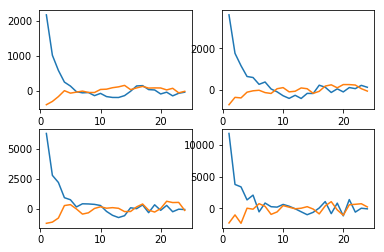

In [46]:
plt.subplot(2, 2, 1)
plt.plot(jdfm.loc[(jdfm.weeks_to_churn > 0) & (jdfm.trend == 1) & \
                  (jdfm.weeks_to_churn < 25),:].groupby('weeks_to_churn').mean()['12wDiffMean'])
plt.plot(jdfm.loc[(jdfm.weeks_to_churn > 0) & (jdfm.trend == 0) & \
                  (jdfm.weeks_to_churn < 25),:].groupby('weeks_to_churn').mean()['12wDiffMean'])


plt.subplot(2, 2, 2)
plt.plot(jdfm.loc[(jdfm.weeks_to_churn > 0) & (jdfm.trend == 1) & \
                  (jdfm.weeks_to_churn < 25),:].groupby('weeks_to_churn').mean()['6wDiffMean'])
plt.plot(jdfm.loc[(jdfm.weeks_to_churn > 0) & (jdfm.trend == 0) & \
                  (jdfm.weeks_to_churn < 25),:].groupby('weeks_to_churn').mean()['6wDiffMean'])

plt.subplot(2, 2, 3)
plt.plot(jdfm.loc[(jdfm.weeks_to_churn > 0) & (jdfm.trend == 1) & \
                  (jdfm.weeks_to_churn < 25),:].groupby('weeks_to_churn').mean()['3wDiffMean'])
plt.plot(jdfm.loc[(jdfm.weeks_to_churn > 0) & (jdfm.trend == 0) & \
                  (jdfm.weeks_to_churn < 25),:].groupby('weeks_to_churn').mean()['3wDiffMean'])

plt.subplot(2, 2, 4)
plt.plot(jdfm.loc[(jdfm.weeks_to_churn > 0) & (jdfm.trend == 1) & \
                  (jdfm.weeks_to_churn < 25),:].groupby('weeks_to_churn').mean()['1wDiffMean'])
plt.plot(jdfm.loc[(jdfm.weeks_to_churn > 0) & (jdfm.trend == 0) & \
                  (jdfm.weeks_to_churn < 25),:].groupby('weeks_to_churn').mean()['1wDiffMean'])


# Model for JDFM

In [47]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [48]:
params = {
    'objective' :'regression',
    'learning_rate' : 0.1,
    'max_depth': 3,
    'num_leaves' : 3,
    'feature_fraction': 1, 
    'bagging_fraction': 0.7, 
    'bagging_freq':1,
    'boosting_type' : 'gbdt',
    'metric': 'rmse'
}

def model4JDFM(params, df, target, nr_fold=5, random_state=1):
    
    clfs = []
    importances = pd.DataFrame()
    folds = StratifiedKFold(n_splits=nr_fold, 
                            shuffle=True, 
                            random_state=random_state)
    
    oof_preds = np.zeros(len(df))
    for fold_, (trn_, val_) in enumerate(folds.split(target, target)):
        trn_x, trn_y = df.iloc[trn_], target.iloc[trn_]
        val_x, val_y = df.iloc[val_], target.iloc[val_]
        
        # making lgbm datasets for train and valid
        d_train = lgbm.Dataset(trn_x, trn_y)
        d_valid = lgbm.Dataset(val_x, val_y)
        
        evals_result = {}
        # training with early stop
        clf = lgbm.train(params, d_train, 500, 
                 valid_sets=[d_train,d_valid], 
                 evals_result=evals_result,
                 verbose_eval=100, 
                 early_stopping_rounds=50)
        
        #ax = lgbm.plot_metric(evals_result, metric='rmse')
        #plt.show()
    
        clfs.append(clf)

        #oof_preds[val_] = clf.predict(val_x)
        print('no {}-fold loss: {}'.format(fold_ + 1, 
              rmse(val_y, clf.predict(val_x))))
        
        oof_preds[val_] = clf.predict(val_x)
    
        imp_df = pd.DataFrame({
                'feature': clf.feature_name(),
                'gain': clf.feature_importance(),
                'fold': [fold_ + 1] * len(df.columns),
                })
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

    score = rmse(target, oof_preds)
    print('rmse : {:.5f}'.format(score))
    #df_importances = save_importances(importances_=importances)
    #df_importances.to_csv('gbm_importances.csv', index=False)
    
    return clfs, score, importances, oof_preds

In [49]:
cols_to_exclude = ['supplier_key', 'level_0',
            'year', 'weekofyear', 'index', 'churn_date', 'churned', 'weeks_to_churn', 'trend',
                  '%change1wVs3DiffMean','diffPeakMin','diffPeakMax','%change1wVs1DiffMean',
                  '%change1w_3mean','losingStrike','winningStrike','3wMean_of_12wDiffMean','timeToPeakSales']
cols = [c for c in jdfm.columns if c not in cols_to_exclude]
jdfm_tr = jdfm.loc[(jdfm.weeks_to_churn > 0) & (jdfm.weeks_to_churn < 52),:]
target = jdfm_tr.weeks_to_churn.copy()
jdfm_tr = jdfm_tr[cols]

In [50]:
clfs, score, importances, oof_preds = model4JDFM(params, jdfm_tr, target, nr_fold=5, random_state=1)

Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 12.738	valid_1's rmse: 12.8898
[200]	training's rmse: 12.151	valid_1's rmse: 12.5426
[300]	training's rmse: 11.6348	valid_1's rmse: 12.2967
[400]	training's rmse: 11.2719	valid_1's rmse: 12.0963
[500]	training's rmse: 10.952	valid_1's rmse: 11.9581
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 10.952	valid_1's rmse: 11.9581
no 1-fold loss: 11.958122637173082
Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 12.6217	valid_1's rmse: 13.2746
[200]	training's rmse: 11.9917	valid_1's rmse: 12.9878
[300]	training's rmse: 11.5117	valid_1's rmse: 12.7525
[400]	training's rmse: 11.1456	valid_1's rmse: 12.6365
[500]	training's rmse: 10.7808	valid_1's rmse: 12.4828
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 10.7808	valid_1's rmse: 12.4828
no 2-fold loss: 12.482787744847094
Training until validation scores don't improve for 50 

In [51]:
importances.groupby('feature').mean().sort_values('gain', ascending = False)

,gain,fold
feature,,
peakSales,165.6,3.0
weeks_from_start,126.2,3.0
peakSalesMin,112.4,3.0
units_ordered,45.2,3.0
15wDiffMean,35.8,3.0
6wDiffMean,32.2,3.0
9wDiffMean,31.2,3.0
12wDiffMean,28.2,3.0
3wDiffMean,26.8,3.0


In [52]:
jdfm_tr['preds'] = oof_preds
jdfm_tr['weeks_to_churn'] = target

Text(0, 0.5, 'Months to churn PRED')

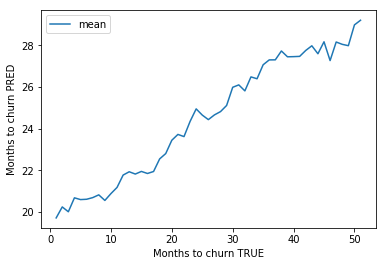

In [53]:
plt.plot(jdfm_tr.loc[jdfm_tr.weeks_to_churn < 151,:].groupby('weeks_to_churn').mean()['preds'])
#plt.plot(jdfm_tr.loc[jdfm_tr.weeks_to_churn < 151,:].groupby('weeks_to_churn').std()['preds'])
plt.legend(['mean', 'std'])
plt.xlabel('Months to churn TRUE')
plt.ylabel('Months to churn PRED')

In [54]:
#maybe that's the waiting period? Let's introduc
#final month could be skewed
#del jdfm['preds']

# Model for AUC

In [55]:
cols_to_exclude = ['supplier_key',
            'year', 'weekofyear', 'index', 'churn_date', 'churned', 'weeks_to_churn', 'trend',
                  'ordered_product_sales_b2b','15wDiffMean','units_ordered_b2b','units_refunded',
                  '%change1wVs1DiffMean','%change1w_3mean','losingStrike','winningStrike','diffPeakMin',
                  'peakSales','level_0','6wMean','3wMean','12wMean','diffOf12wMean','timeToPeakSales']
cols = [c for c in jdfm.columns if c not in cols_to_exclude]
jdfm_tr = jdfm.loc[jdfm.weeks_to_churn > 0,:]
target = jdfm_tr.weeks_to_churn.copy()
target_ori = jdfm_tr.weeks_to_churn.copy()
trend = jdfm_tr.trend.copy()
jdfm_tr = jdfm_tr[cols]
target.loc[target > 1] = 0

params = {
    'objective' :'binary',
    'learning_rate' : 0.1,
    'max_depth': 3,
    'num_leaves' : 3,
    'feature_fraction': 1, 
    'bagging_fraction': 0.6, 
    'bagging_freq':1,
    'boosting_type' : 'gbdt',
    'metric': 'auc',
    'lambda_l1': 0,
    'lambda_l2': 0
}

def model4JDFM_AUC(params, df, target, nr_fold=5, random_state=1):
    
    clfs = []
    importances = pd.DataFrame()
    folds = StratifiedKFold(n_splits=nr_fold, 
                            shuffle=True, 
                            random_state=random_state)
    
    oof_preds = np.zeros(len(df))
    for fold_, (trn_, val_) in enumerate(folds.split(target, target)):
        trn_x, trn_y = df.iloc[trn_], target.iloc[trn_]
        val_x, val_y = df.iloc[val_], target.iloc[val_]
        
        # making lgbm datasets for train and valid
        d_train = lgbm.Dataset(trn_x, trn_y)
        d_valid = lgbm.Dataset(val_x, val_y)
        
        evals_result = {}
        # training with early stop
        clf = lgbm.train(params, d_train, 500, 
                 valid_sets=[d_train,d_valid], 
                 evals_result=evals_result,
                 verbose_eval=100, 
                 early_stopping_rounds=50)
        
        #ax = lgbm.plot_metric(evals_result, metric='auc')
        #plt.show()
    
        clfs.append(clf)

        #oof_preds[val_] = clf.predict(val_x)
        print('no {}-fold loss: {}'.format(fold_ + 1, 
              roc_auc_score(val_y, clf.predict(val_x))))
        
        oof_preds[val_] = clf.predict(val_x)
    
        imp_df = pd.DataFrame({
                'feature': clf.feature_name(),
                'gain': clf.feature_importance(),
                'fold': [fold_ + 1] * len(df.columns),
                })
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

    score = roc_auc_score(target, oof_preds)
    print('roc : {:.5f}'.format(score))
    #df_importances = save_importances(importances_=importances)
    #df_importances.to_csv('gbm_importances.csv', index=False)
    
    return clfs, score, importances, oof_preds

In [56]:
clfs, score, importances, oof_preds = model4JDFM_AUC(params, jdfm_tr, target, nr_fold=5, random_state=1)

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[17]	training's auc: 0.828565	valid_1's auc: 0.790281
no 1-fold loss: 0.790281455329999
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[32]	training's auc: 0.864089	valid_1's auc: 0.731417
no 2-fold loss: 0.7314172702522217
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[35]	training's auc: 0.865986	valid_1's auc: 0.793848
no 3-fold loss: 0.7938478143550998
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[45]	training's auc: 0.892584	valid_1's auc: 0.662054
no 4-fold loss: 0.6620538123506283
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	training's auc: 0.828835	valid_1's auc: 0.736194
no 5-fold loss: 0.7361935599928043
roc : 0.73380


In [57]:
importances.groupby('feature').mean().sort_values('gain', ascending = False)

,gain,fold
feature,,
weeks_from_start,9.0,3.0
6wDiffMean,6.6,3.0
1wDiffMean,6.2,3.0
diffPeakMax,6.0,3.0
9wDiffMean,4.8,3.0
ordered_product_sales,4.2,3.0
12wDiffMean,4.0,3.0
3wMean_of_12wDiffMean,4.0,3.0
2wDiffMean,3.6,3.0


In [58]:
jdfm_tr['preds'] = oof_preds
jdfm_tr['weeks_to_churn'] = target_ori
jdfm_tr['trend'] = trend

Text(0, 0.5, 'Probability of to churn')

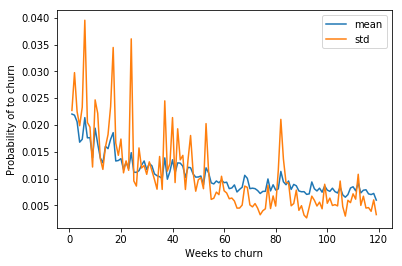

In [59]:
plt.plot(jdfm_tr.loc[jdfm_tr.weeks_to_churn < 120,:].groupby('weeks_to_churn').mean()['preds'])
plt.plot(jdfm_tr.loc[jdfm_tr.weeks_to_churn < 120,:].groupby('weeks_to_churn').std()['preds'])
plt.legend(['mean', 'std'])
plt.xlabel('Weeks to churn')
plt.ylabel('Probability of to churn')

In [60]:
t1 = jdfm_tr.loc[(jdfm_tr.weeks_to_churn > 0) & (jdfm_tr.trend == 1) & \
                  (jdfm.weeks_to_churn < 120),:].groupby('weeks_to_churn').mean()['6wDiffMean']
t2 = jdfm_tr.loc[(jdfm_tr.weeks_to_churn > 0) & (jdfm_tr.trend == 0) & \
                  (jdfm_tr.weeks_to_churn < 120),:].groupby('weeks_to_churn').mean()['6wDiffMean']
t3 = jdfm_tr.loc[(jdfm_tr.weeks_to_churn > 0) & (jdfm_tr.trend == 0) & \
                  (jdfm_tr.weeks_to_churn < 120),:].groupby('weeks_to_churn').mean()['preds']

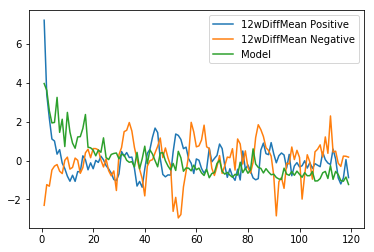

In [61]:
plt.plot((t1 - t1.mean()) / t1.std())
plt.plot((t2 - t2.mean()) / t2.std())
plt.plot((t3 - t3.mean()) / t3.std())
plt.legend(['12wDiffMean Positive','12wDiffMean Negative','Model'])

The model doesn't get as high as 12wDiffMean when pointing out customers who had outgrown Payability but is way more stable

Things to  try:
- Survival Analysis
- Data related to users which didn't convert yet
- LSTM
- Add other data about customer (category of sales)
- add monthly aggregations
- add YOY data
- add trend data without seasonality